# Interpretability, Stability and Algorithmic Fairness Project


## Step 0. Import packages and load data

In [1]:
# ============================================================================
# IMPORTS - All necessary libraries for the entire project
# ============================================================================

# Data manipulation and analysis
import numpy as np 
import pandas as pd
from ydata_profiling import ProfileReport
from typing import Tuple, Sequence

# Machine learning libraries
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, average_precision_score
from lightgbm import LGBMClassifier

# Utilities
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Load the loan dataset
df_n = pd.read_csv("data/dataproject2025.csv")

In [3]:
# Check for missing values in the dataset
df_n.isna().sum()

Unnamed: 0                 0
issue_d                    0
loan duration              0
annual_inc                 0
avg_cur_bal                0
bc_open_to_buy             0
bc_util                    0
delinq_2yrs                0
dti                        0
emp_length                 0
emp_title                  0
fico_range_high            0
funded_amnt                0
grade                      0
home_ownership             0
inq_last_6mths             0
int_rate                   0
mo_sin_old_rev_tl_op       0
mo_sin_rcnt_rev_tl_op      0
mo_sin_rcnt_tl             0
mort_acc                   0
mths_since_recent_bc       0
num_actv_bc_tl             0
num_bc_tl                  0
num_il_tl                  0
num_rev_accts              0
open_acc                   0
pub_rec                    0
pub_rec_bankruptcies       0
purpose                    0
revol_bal                  0
revol_util                 0
sub_grade                  0
target                     0
tax_liens     

In [4]:
# Remove rows with missing values for clean analysis
df = df_n.dropna()

In [5]:
df.head()

,Unnamed: 0,issue_d,loan duration,annual_inc,avg_cur_bal,bc_open_to_buy,bc_util,delinq_2yrs,dti,emp_length,...,purpose,revol_bal,revol_util,sub_grade,target,tax_liens,zip_code,Pct_afro_american,Predictions,Predicted probabilities
0,0,2013,0,39600.0,1379.0,21564.0,16.1,0.0,2.49,2 years,...,home_improvement,4136.0,16.1,B2,0,0.0,782,7.388592,0,0.053051
1,1,2013,0,55000.0,9570.0,16473.0,53.9,0.0,22.87,10+ years,...,debt_consolidation,36638.0,61.2,B2,0,0.0,481,9.745456,0,0.084507
2,2,2013,0,325000.0,53306.0,13901.0,67.1,0.0,18.55,5 years,...,debt_consolidation,29581.0,54.6,A3,0,0.0,945,7.542862,0,0.037206
3,3,2013,0,130000.0,36362.0,3567.0,93.0,0.0,13.03,10+ years,...,debt_consolidation,10805.0,67.0,B3,0,0.0,809,6.598132,0,0.061371
4,4,2013,1,73000.0,24161.0,4853.0,74.7,1.0,23.13,6 years,...,debt_consolidation,27003.0,82.8,D5,1,0.0,802,7.058900,1,0.345896


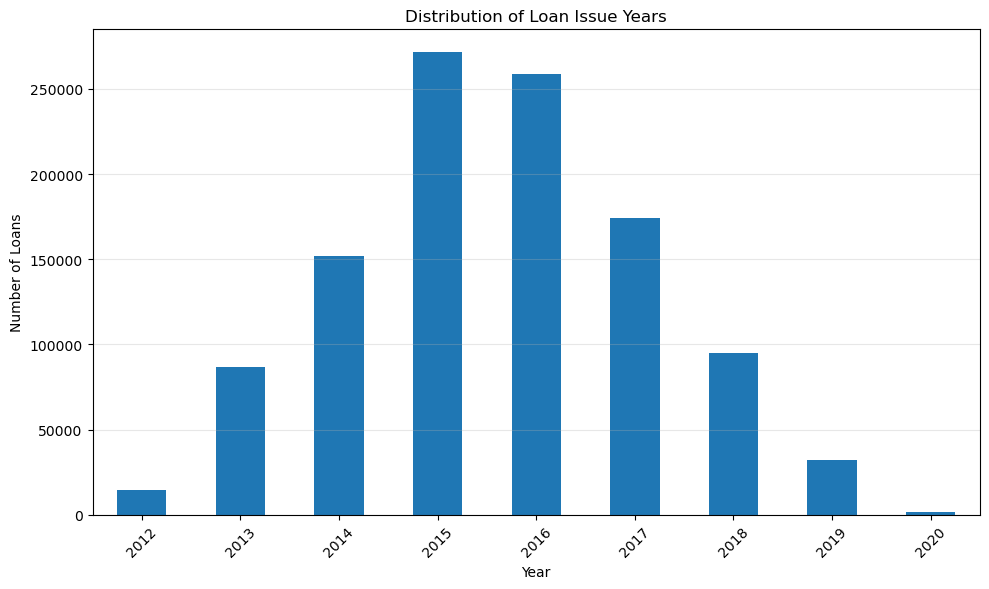

Year-wise loan counts:
issue_d
2012     14324
2013     86574
2014    152117
2015    271416
2016    258793
2017    173921
2018     94893
2019     32368
2020      1830
Name: count, dtype: int64


In [6]:
# Plot the distribution of issue_d (year) column
import matplotlib.pyplot as plt

# Create a histogram of the issue_d years
plt.figure(figsize=(10, 6))
df["issue_d"].value_counts().sort_index().plot(kind='bar')
plt.title('Distribution of Loan Issue Years')
plt.xlabel('Year')
plt.ylabel('Number of Loans')
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# Also show the counts as a table
print("Year-wise loan counts:")
print(df["issue_d"].value_counts().sort_index())

In [7]:
# Check column names and data types
print("Columns:", df.columns.tolist())
print("\nData types:")
print(df.dtypes)
print(f"\nDataframe shape: {df.shape}")

Columns: ['Unnamed: 0', 'issue_d', 'loan duration', 'annual_inc', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util', 'delinq_2yrs', 'dti', 'emp_length', 'emp_title', 'fico_range_high', 'funded_amnt', 'grade', 'home_ownership', 'inq_last_6mths', 'int_rate', 'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl', 'mort_acc', 'mths_since_recent_bc', 'num_actv_bc_tl', 'num_bc_tl', 'num_il_tl', 'num_rev_accts', 'open_acc', 'pub_rec', 'pub_rec_bankruptcies', 'purpose', 'revol_bal', 'revol_util', 'sub_grade', 'target', 'tax_liens', 'zip_code', 'Pct_afro_american', 'Predictions', 'Predicted probabilities']

Data types:
Unnamed: 0                   int64
issue_d                      int64
loan duration                int64
annual_inc                 float64
avg_cur_bal                float64
bc_open_to_buy             float64
bc_util                    float64
delinq_2yrs                float64
dti                        float64
emp_length                  object
emp_title                  

In [8]:
# profile1 = ProfileReport(df, title="Pandas Profiling Report")

In [9]:
# profile1

In [10]:
for col in df.select_dtypes(include="object").columns:
    print(f"Column: {col}")
    print(df[col].unique())
    print("-" * 50)

Column: emp_length
['2 years' '10+ years' '5 years' '6 years' '4 years' '3 years' '9 years'
 '8 years' '1 year' '< 1 year' '7 years']
--------------------------------------------------
Column: emp_title
['other' 'sales manager' 'driver' 'operations manager' 'teacher'
 'associate' 'business analyst' 'manager' 'customer service'
 'administrative assistant' 'general manager' 'vice president'
 'supervisor' 'administrator' 'project manager' 'nurse' 'electrician'
 'account manager' 'sales' 'director' 'technician'
 'chief executive officer' 'engineer' 'mechanic' 'truck driver'
 'executive assistant' 'customer service representative'
 'software engineer' 'operator' 'office manager' 'analyst'
 'police officer' 'owner' 'consultant' 'store manager' 'accountant'
 'account executive' 'attorney' 'server' 'financial analyst' 'maintenance'
 'clerk' 'superintendent' 'president' 'program manager'
 'assistant manager' 'machine operator' 'controller' 'paralegal' 'foreman'
 'branch manager']
--------------

In [11]:
df['issue_d'].value_counts()

issue_d
2015    271416
2016    258793
2017    173921
2014    152117
2018     94893
2013     86574
2019     32368
2012     14324
2020      1830
Name: count, dtype: int64

## Step 1.

## Step 2. 

In [12]:
# Prepare feature matrix X and target vector y
# Remove unnecessary columns (index, target, and existing predictions)
X = df.drop(columns=['Unnamed: 0', 'target', 'Predictions', 'Predicted probabilities'])
y = df['target']

### Time-based Train/Validation/Test Split

Using time-based splitting to prevent data leakage and simulate real-world prediction scenarios.

In [13]:
def train_val_test_split_by_year(
    df: pd.DataFrame,
    year_col: str,
    train_end: int,
    val_end: int,
    feature_cols: Sequence[str],
    target_col: str
) -> Tuple[pd.DataFrame, pd.Series,
           pd.DataFrame, pd.Series,
           pd.DataFrame, pd.Series]:
    """
    Time-based split into train/val/test:
      train: year <= train_end
      val  : train_end < year <= val_end
      test : year > val_end
    Assumes df[year_col] is already integer years.
    """
    year = df[year_col].astype(int)

    train_mask = year <= train_end
    val_mask   = (year > train_end) & (year <= val_end)
    test_mask  = year > val_end

    X_train = df.loc[train_mask, feature_cols]
    y_train = df.loc[train_mask, target_col]

    X_val   = df.loc[val_mask, feature_cols]
    y_val   = df.loc[val_mask, target_col]

    X_test  = df.loc[test_mask, feature_cols]
    y_test  = df.loc[test_mask, target_col]

    return X_train, y_train, X_val, y_val, X_test, y_test


X_train, y_train, X_val, y_val, X_test, y_test = train_val_test_split_by_year(
    df,
    year_col='issue_d',
    train_end=2016,   # train: <= 2016
    val_end=2017,     # val: = 2017
    feature_cols=X.columns.tolist(),
    target_col='target'
)

print(f"Train set: {X_train.shape}, Val set: {X_val.shape}, Test set: {X_test.shape}")
print("Class distribution train:", y_train.value_counts(normalize=True).round(3).to_dict())
print("Class distribution val  :", y_val.value_counts(normalize=True).round(3).to_dict())
print("Class distribution test :", y_test.value_counts(normalize=True).round(3).to_dict())

Train set: (783224, 35), Val set: (173921, 35), Test set: (129091, 35)
Class distribution train: {0: 0.797, 1: 0.203}
Class distribution val  : {0: 0.773, 1: 0.227}
Class distribution test : {0: 0.767, 1: 0.233}


### Feature Engineering Pipeline

Setting up preprocessing for different feature types: numerical, ordinal, and categorical.

In [14]:
# Define feature categories for preprocessing
ordinal_features = ["emp_length"]  # Features with natural ordering
onehot_features = ["home_ownership", "purpose", "emp_title"]  # Categorical features
numerical_features = X.select_dtypes(exclude=['object']).columns.tolist()  # Continuous features
numerical_features.remove("issue_d") #delete issu_d for interpreting purpose

# Define custom ordering for employment length (ordinal encoding)
emp_length_order = ["< 1 year", "1 year", "2 years", "3 years", "4 years",
                    "5 years", "6 years", "7 years", "8 years", "9 years", "10+ years"]

# Create ordinal encoder with custom ordering
ord_encoder = OrdinalEncoder(
    categories=[emp_length_order],
    handle_unknown="use_encoded_value",
    unknown_value=-1
)

# Build preprocessing pipeline with different transformers for different feature types
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numerical_features),  # Scale numerical features
        ("ord", ord_encoder, ordinal_features),  # Encode ordinal features
        ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False), onehot_features),  # One-hot encode categorical
    ]
)

### Baseline Model Training

Training LightGBM models with default and balanced class weights for comparison.

In [15]:
# Train baseline LightGBM model (no class balancing)
lgbm_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("classifier", LGBMClassifier(
        # class_weight="balanced",  # Commented out for baseline
        random_state=42,
        verbose=-1
    ))
])

lgbm_pipeline.fit(X_train, y_train)
y_pred = lgbm_pipeline.predict(X_val)
y_proba = lgbm_pipeline.predict_proba(X_val)[:, 1]

print("LightGBM - Accuracy:", round(accuracy_score(y_val, y_pred), 4))
print("LightGBM - AUC:", round(roc_auc_score(y_val, y_proba), 4))
print("\nClassification Report:\n", classification_report(y_val, y_pred))

LightGBM - Accuracy: 0.7784
LightGBM - AUC: 0.7101

Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.98      0.87    134488
           1       0.59      0.08      0.13     39433

    accuracy                           0.78    173921
   macro avg       0.69      0.53      0.50    173921
weighted avg       0.74      0.78      0.71    173921


Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.98      0.87    134488
           1       0.59      0.08      0.13     39433

    accuracy                           0.78    173921
   macro avg       0.69      0.53      0.50    173921
weighted avg       0.74      0.78      0.71    173921



In [16]:
# Train LightGBM with balanced class weights to handle class imbalance
lgbm_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("classifier", LGBMClassifier(
        class_weight="balanced",  # Automatically balance class weights
        random_state=42,
        verbose=-1
    ))
])

lgbm_pipeline.fit(X_train, y_train)
y_pred = lgbm_pipeline.predict(X_val)
y_proba = lgbm_pipeline.predict_proba(X_val)[:, 1]

print("LightGBM_balanced - Accuracy:", round(accuracy_score(y_val, y_pred), 4))
print("LightGBM_balanced - AUC:", round(roc_auc_score(y_val, y_proba), 4))
print("\nClassification Report:\n", classification_report(y_val, y_pred))

LightGBM_balanced - Accuracy: 0.6628
LightGBM_balanced - AUC: 0.71

Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.67      0.76    134488
           1       0.36      0.63      0.46     39433

    accuracy                           0.66    173921
   macro avg       0.61      0.65      0.61    173921
weighted avg       0.75      0.66      0.69    173921


Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.67      0.76    134488
           1       0.36      0.63      0.46     39433

    accuracy                           0.66    173921
   macro avg       0.61      0.65      0.61    173921
weighted avg       0.75      0.66      0.69    173921



### Hyperparameter Optimization

The following cell contains commented Optuna code for hyperparameter tuning. The best parameters found are used in subsequent cells.

In [17]:
# # Optuna tuning for LightGBM (optimize ROC-AUC) with fixed validation set
# import optuna

# warnings.filterwarnings("ignore")

# # Positive class is 1 (charged-off)
# pos = int((y_train == 1).sum())
# neg = int((y_train == 0).sum())
# spw_base = max(neg / max(pos, 1), 1.0)

# def make_lgbm(trial):
#     return LGBMClassifier(
#         n_estimators      = trial.suggest_int("n_estimators", 300, 1500),
#         learning_rate     = trial.suggest_float("learning_rate", 0.02, 0.2, log=True),
#         num_leaves        = trial.suggest_int("num_leaves", 31, 255),
#         max_depth         = trial.suggest_int("max_depth", -1, 12),
#         min_child_samples = trial.suggest_int("min_child_samples", 20, 200),
#         min_child_weight  = trial.suggest_float("min_child_weight", 1e-3, 10.0, log=True),
#         subsample         = trial.suggest_float("subsample", 0.6, 1.0),
#         colsample_bytree  = trial.suggest_float("colsample_bytree", 0.6, 1.0),
#         reg_alpha         = trial.suggest_float("reg_alpha", 1e-8, 10.0, log=True),
#         reg_lambda        = trial.suggest_float("reg_lambda", 1e-8, 10.0, log=True),

#         scale_pos_weight  = spw_base,
#         n_jobs            = -1,
#         random_state      = 42,
#     )

# def objective(trial):
#     clf = make_lgbm(trial)
#     pipe = Pipeline([("preprocessor", preprocessor), ("clf", clf)])
#     pipe.fit(X_train, y_train)
#     proba = pipe.predict_proba(X_val)[:, 1]
#     ap  = average_precision_score(y_val, proba)
#     auc = roc_auc_score(y_val, proba)
#     # primary: AP; small tie-breaker with ROC
#     return float(ap + 1e-3 * auc)

# sampler = optuna.samplers.TPESampler(seed=42)
# pruner  = optuna.pruners.MedianPruner(n_warmup_steps=10)
# study = optuna.create_study(direction="maximize", sampler=sampler, pruner=pruner)
# study.optimize(objective, n_trials=40, gc_after_trial=True)

# print("Best value :", study.best_value)
# print("Best params:", study.best_trial.params)


In [18]:
"""
[I 2025-09-25 14:31:01,743] A new study created in memory with name: no-name-a73ef694-a0e6-4ca9-9626-a8e302a9e9d8
[I 2025-09-25 14:31:15,838] Trial 0 finished with value: 0.4124885635244692 and parameters: {'n_estimators': 749, 'learning_rate': 0.1785436060870726, 'num_leaves': 195, 'max_depth': 7, 'min_child_samples': 48, 'min_child_weight': 0.004207053950287938, 'subsample': 0.6232334448672797, 'colsample_bytree': 0.9464704583099741, 'reg_alpha': 0.002570603566117598, 'reg_lambda': 0.023585940584142682}. Best is trial 0 with value: 0.4124885635244692.
[I 2025-09-25 14:31:21,684] Trial 1 finished with value: 0.40355827811404454 and parameters: {'n_estimators': 324, 'learning_rate': 0.18661212048851336, 'num_leaves': 218, 'max_depth': 1, 'min_child_samples': 52, 'min_child_weight': 0.00541524411940254, 'subsample': 0.7216968971838151, 'colsample_bytree': 0.8099025726528951, 'reg_alpha': 7.71800699380605e-05, 'reg_lambda': 4.17890272377219e-06}. Best is trial 0 with value: 0.4124885635244692.
[I 2025-09-25 14:31:44,865] Trial 2 finished with value: 0.4188036311261316 and parameters: {'n_estimators': 1034, 'learning_rate': 0.027575529238707534, 'num_leaves': 96, 'max_depth': 4, 'min_child_samples': 102, 'min_child_weight': 1.382623217936987, 'subsample': 0.6798695128633439, 'colsample_bytree': 0.8056937753654446, 'reg_alpha': 0.0021465011216654484, 'reg_lambda': 2.6185068507773707e-08}. Best is trial 2 with value: 0.4188036311261316.
[I 2025-09-25 14:32:38,202] Trial 3 finished with value: 0.42350184158517185 and parameters: {'n_estimators': 1029, 'learning_rate': 0.029617890239950373, 'num_leaves': 45, 'max_depth': 12, 'min_child_samples': 194, 'min_child_weight': 1.7123375973163988, 'subsample': 0.7218455076693483, 'colsample_bytree': 0.6390688456025535, 'reg_alpha': 0.014391207615728067, 'reg_lambda': 9.148975058772307e-05}. Best is trial 3 with value: 0.42350184158517185.
[I 2025-09-25 14:33:00,175] Trial 4 finished with value: 0.4218262576178775 and parameters: {'n_estimators': 446, 'learning_rate': 0.06254706073560744, 'num_leaves': 38, 'max_depth': 11, 'min_child_samples': 66, 'min_child_weight': 0.4467752817973907, 'subsample': 0.7246844304357644, 'colsample_bytree': 0.8080272084711243, 'reg_alpha': 0.0008325158565947976, 'reg_lambda': 4.609885087947832e-07}. Best is trial 3 with value: 0.42350184158517185.
[I 2025-09-25 14:35:47,283] Trial 5 finished with value: 0.4035570553299044 and parameters: {'n_estimators': 1464, 'learning_rate': 0.11916886939345038, 'num_leaves': 242, 'max_depth': 11, 'min_child_samples': 128, 'min_child_weight': 4.869640941520899, 'subsample': 0.6353970008207678, 'colsample_bytree': 0.6783931449676581, 'reg_alpha': 2.5529693461039728e-08, 'reg_lambda': 8.471746987003668e-06}. Best is trial 3 with value: 0.42350184158517185.
[I 2025-09-25 14:36:14,349] Trial 6 finished with value: 0.41429467074713594 and parameters: {'n_estimators': 766, 'learning_rate': 0.03735760514214135, 'num_leaves': 217, 'max_depth': 3, 'min_child_samples': 70, 'min_child_weight': 0.14817820606039092, 'subsample': 0.6563696899899051, 'colsample_bytree': 0.9208787923016158, 'reg_alpha': 4.6876566400928895e-08, 'reg_lambda': 7.620481786158549}. Best is trial 3 with value: 0.42350184158517185.
[I 2025-09-25 14:37:20,413] Trial 7 finished with value: 0.42343067840579596 and parameters: {'n_estimators': 1227, 'learning_rate': 0.031604263728207765, 'num_leaves': 32, 'max_depth': 10, 'min_child_samples': 147, 'min_child_weight': 0.8241925264876453, 'subsample': 0.9085081386743783, 'colsample_bytree': 0.6296178606936361, 'reg_alpha': 1.683416412018213e-05, 'reg_lambda': 1.1036250149900698e-07}. Best is trial 3 with value: 0.42350184158517185.
[I 2025-09-25 14:38:37,439] Trial 8 finished with value: 0.418566322579012 and parameters: {'n_estimators': 1336, 'learning_rate': 0.084009446334044, 'num_leaves': 105, 'max_depth': -1, 'min_child_samples': 76, 'min_child_weight': 0.01998634077852888, 'subsample': 0.8918424713352255, 'colsample_bytree': 0.8550229885420852, 'reg_alpha': 0.9658611176861268, 'reg_lambda': 0.0001778010520878397}. Best is trial 3 with value: 0.42350184158517185.
[I 2025-09-25 14:38:48,874] Trial 9 finished with value: 0.42515698690294507 and parameters: {'n_estimators': 443, 'learning_rate': 0.10334150520046555, 'num_leaves': 202, 'max_depth': 6, 'min_child_samples': 159, 'min_child_weight': 0.09444574254983566, 'subsample': 0.8090931317527976, 'colsample_bytree': 0.7710164073434198, 'reg_alpha': 1.6934490731313353e-08, 'reg_lambda': 9.354548757337708e-08}. Best is trial 9 with value: 0.42515698690294507.
[I 2025-09-25 14:39:03,224] Trial 10 finished with value: 0.425116219535296 and parameters: {'n_estimators': 549, 'learning_rate': 0.059478131551414695, 'num_leaves': 168, 'max_depth': 7, 'min_child_samples': 180, 'min_child_weight': 0.03717702150126786, 'subsample': 0.8208781805340754, 'colsample_bytree': 0.7156237038334943, 'reg_alpha': 8.46106948686665e-07, 'reg_lambda': 0.010367714070333529}. Best is trial 9 with value: 0.42515698690294507.
[I 2025-09-25 14:39:17,790] Trial 11 finished with value: 0.4245596698774353 and parameters: {'n_estimators': 521, 'learning_rate': 0.05507813170238614, 'num_leaves': 165, 'max_depth': 7, 'min_child_samples': 181, 'min_child_weight': 0.03740962387403666, 'subsample': 0.8224761781765364, 'colsample_bytree': 0.7178822054585058, 'reg_alpha': 8.76040867180857e-07, 'reg_lambda': 0.02419584192691601}. Best is trial 9 with value: 0.42515698690294507.
[I 2025-09-25 14:39:48,665] Trial 12 finished with value: 0.42322609920655313 and parameters: {'n_estimators': 609, 'learning_rate': 0.09785129931240315, 'num_leaves': 153, 'max_depth': 8, 'min_child_samples': 159, 'min_child_weight': 0.10044782868101039, 'subsample': 0.8221524940198316, 'colsample_bytree': 0.7371197153065265, 'reg_alpha': 1.283750567305851e-06, 'reg_lambda': 0.010120698664942676}. Best is trial 9 with value: 0.42515698690294507.
[I 2025-09-25 14:40:12,002] Trial 13 finished with value: 0.41855995558945264 and parameters: {'n_estimators': 304, 'learning_rate': 0.04587270929523388, 'num_leaves': 181, 'max_depth': 6, 'min_child_samples': 166, 'min_child_weight': 0.020334906684860966, 'subsample': 0.9724891986137659, 'colsample_bytree': 0.7389455428332762, 'reg_alpha': 5.960361308700738e-07, 'reg_lambda': 0.8251356297038612}. Best is trial 9 with value: 0.42515698690294507.
[I 2025-09-25 14:40:36,772] Trial 14 finished with value: 0.42338419098905056 and parameters: {'n_estimators': 701, 'learning_rate': 0.0841644837632613, 'num_leaves': 124, 'max_depth': 4, 'min_child_samples': 128, 'min_child_weight': 0.001879254833690615, 'subsample': 0.8647080858469188, 'colsample_bytree': 0.6954213319864813, 'reg_alpha': 1.2557486015764376e-08, 'reg_lambda': 0.0025363951381964945}. Best is trial 9 with value: 0.42515698690294507.
[I 2025-09-25 14:41:11,412] Trial 15 finished with value: 0.40885910798908487 and parameters: {'n_estimators': 480, 'learning_rate': 0.13855097720691706, 'num_leaves': 255, 'max_depth': 9, 'min_child_samples': 20, 'min_child_weight': 0.17352840584427187, 'subsample': 0.7807775475387444, 'colsample_bytree': 0.869308716305864, 'reg_alpha': 8.950924485478923e-06, 'reg_lambda': 0.17988154860497957}. Best is trial 9 with value: 0.42515698690294507.
[I 2025-09-25 14:41:53,717] Trial 16 finished with value: 0.41926484887354076 and parameters: {'n_estimators': 925, 'learning_rate': 0.021293596590604497, 'num_leaves': 196, 'max_depth': 5, 'min_child_samples': 197, 'min_child_weight': 0.04556263914101204, 'subsample': 0.7752036656043477, 'colsample_bytree': 0.758229806954334, 'reg_alpha': 1.7846159484277026e-07, 'reg_lambda': 1.6222441544563988e-05}. Best is trial 9 with value: 0.42515698690294507.
[I 2025-09-25 14:42:11,603] Trial 17 finished with value: 0.4118289416622911 and parameters: {'n_estimators': 608, 'learning_rate': 0.0740544898164958, 'num_leaves': 126, 'max_depth': 2, 'min_child_samples': 142, 'min_child_weight': 0.009759295710164394, 'subsample': 0.9397411492889054, 'colsample_bytree': 0.6681845114128452, 'reg_alpha': 8.019073278911363e-06, 'reg_lambda': 0.0010378973903210163}. Best is trial 9 with value: 0.42515698690294507.
[I 2025-09-25 14:42:35,804] Trial 18 finished with value: 0.42157449741212843 and parameters: {'n_estimators': 424, 'learning_rate': 0.04829959080147578, 'num_leaves': 170, 'max_depth': 6, 'min_child_samples': 175, 'min_child_weight': 0.29612980435114955, 'subsample': 0.8607769576771078, 'colsample_bytree': 0.7757701652042633, 'reg_alpha': 5.0363789132431, 'reg_lambda': 2.455918006464903e-08}. Best is trial 9 with value: 0.42515698690294507.
[I 2025-09-25 14:43:28,486] Trial 19 finished with value: 0.4165545878858035 and parameters: {'n_estimators': 867, 'learning_rate': 0.11726235890480016, 'num_leaves': 220, 'max_depth': 8, 'min_child_samples': 108, 'min_child_weight': 0.04325180977713664, 'subsample': 0.7757526351833268, 'colsample_bytree': 0.9925252347033172, 'reg_alpha': 1.3941020893526537e-07, 'reg_lambda': 5.691318929182572e-07}. Best is trial 9 with value: 0.42515698690294507.
[I 2025-09-25 14:44:10,503] Trial 20 finished with value: 0.42662436252483843 and parameters: {'n_estimators': 595, 'learning_rate': 0.06990305155464922, 'num_leaves': 141, 'max_depth': 9, 'min_child_samples': 153, 'min_child_weight': 0.001230049810567648, 'subsample': 0.8290486446477119, 'colsample_bytree': 0.6085543667444748, 'reg_alpha': 0.041020624131075656, 'reg_lambda': 0.3458102879777702}. Best is trial 20 with value: 0.42662436252483843.
[I 2025-09-25 14:45:00,404] Trial 21 finished with value: 0.42523874563720027 and parameters: {'n_estimators': 599, 'learning_rate': 0.06834142840894819, 'num_leaves': 140, 'max_depth': 9, 'min_child_samples': 146, 'min_child_weight': 0.0011158620966087484, 'subsample': 0.8393544337390497, 'colsample_bytree': 0.6114948874411064, 'reg_alpha': 0.05294054339532663, 'reg_lambda': 0.34285796837860133}. Best is trial 20 with value: 0.42662436252483843.
[I 2025-09-25 14:45:51,135] Trial 22 finished with value: 0.42460311640464815 and parameters: {'n_estimators': 661, 'learning_rate': 0.07811642157174385, 'num_leaves': 136, 'max_depth': 9, 'min_child_samples': 147, 'min_child_weight': 0.0012454733585249747, 'subsample': 0.8520987322399567, 'colsample_bytree': 0.6021625329242458, 'reg_alpha': 0.07415111704352027, 'reg_lambda': 8.296641909219783}. Best is trial 20 with value: 0.42662436252483843.
[I 2025-09-25 14:46:15,163] Trial 23 finished with value: 0.4234969830092411 and parameters: {'n_estimators': 388, 'learning_rate': 0.1040550254710474, 'num_leaves': 69, 'max_depth': 9, 'min_child_samples': 130, 'min_child_weight': 0.0022552629979310755, 'subsample': 0.7485202093651705, 'colsample_bytree': 0.61109800293869, 'reg_alpha': 0.1577631783193009, 'reg_lambda': 0.4438475286373584}. Best is trial 20 with value: 0.42662436252483843.
[I 2025-09-25 14:47:01,669] Trial 24 finished with value: 0.41530394278724314 and parameters: {'n_estimators': 801, 'learning_rate': 0.1472842743065627, 'num_leaves': 102, 'max_depth': 10, 'min_child_samples': 158, 'min_child_weight': 0.001002417059933003, 'subsample': 0.8997072981824707, 'colsample_bytree': 0.649696188386054, 'reg_alpha': 0.02725912411723744, 'reg_lambda': 0.1205912196762187}. Best is trial 20 with value: 0.42662436252483843.
[I 2025-09-25 14:47:49,224] Trial 25 finished with value: 0.42367890658860113 and parameters: {'n_estimators': 541, 'learning_rate': 0.06901447649282681, 'num_leaves': 145, 'max_depth': 12, 'min_child_samples': 98, 'min_child_weight': 0.005903759212668298, 'subsample': 0.8022304054975694, 'colsample_bytree': 0.6002684078306731, 'reg_alpha': 0.3407068582238012, 'reg_lambda': 2.9959665602009067}. Best is trial 20 with value: 0.42662436252483843.
[I 2025-09-25 14:48:01,891] Trial 26 finished with value: 0.4247375108270009 and parameters: {'n_estimators': 658, 'learning_rate': 0.09933348774611177, 'num_leaves': 119, 'max_depth': 5, 'min_child_samples': 119, 'min_child_weight': 6.111781182391502, 'subsample': 0.9367531787495578, 'colsample_bytree': 0.6565206563909913, 'reg_alpha': 0.0001340165181838073, 'reg_lambda': 0.0864774300427382}. Best is trial 20 with value: 0.42662436252483843.
[I 2025-09-25 14:48:14,870] Trial 27 finished with value: 0.42236927760059506 and parameters: {'n_estimators': 391, 'learning_rate': 0.04365097024942366, 'num_leaves': 76, 'max_depth': 8, 'min_child_samples': 142, 'min_child_weight': 0.010420352810072513, 'subsample': 0.8510992495340646, 'colsample_bytree': 0.8517156611049723, 'reg_alpha': 0.01063205588978806, 'reg_lambda': 1.4681671774018707}. Best is trial 20 with value: 0.42662436252483843.
[I 2025-09-25 14:48:49,203] Trial 28 finished with value: 0.4251133501664635 and parameters: {'n_estimators': 962, 'learning_rate': 0.05254161945222833, 'num_leaves': 191, 'max_depth': 10, 'min_child_samples': 165, 'min_child_weight': 0.002361728562015331, 'subsample': 0.7590087532174032, 'colsample_bytree': 0.6315173012723327, 'reg_alpha': 4.245827031110886, 'reg_lambda': 0.001447551090021519}. Best is trial 20 with value: 0.42662436252483843.
[I 2025-09-25 14:49:09,412] Trial 29 finished with value: 0.4211619344049207 and parameters: {'n_estimators': 793, 'learning_rate': 0.13502987900006488, 'num_leaves': 155, 'max_depth': 7, 'min_child_samples': 93, 'min_child_weight': 0.004012587515523726, 'subsample': 0.8132890804996505, 'colsample_bytree': 0.8914058771564304, 'reg_alpha': 0.004031021171445679, 'reg_lambda': 4.053140892519326e-05}. Best is trial 20 with value: 0.42662436252483843.
[I 2025-09-25 14:49:24,588] Trial 30 finished with value: 0.42538270681941004 and parameters: {'n_estimators': 574, 'learning_rate': 0.06576812450624586, 'num_leaves': 194, 'max_depth': 6, 'min_child_samples': 151, 'min_child_weight': 0.011243822656371093, 'subsample': 0.9992790868195935, 'colsample_bytree': 0.696223209699688, 'reg_alpha': 1.5322413985956158, 'reg_lambda': 0.030220602303410005}. Best is trial 20 with value: 0.42662436252483843.
[I 2025-09-25 14:49:39,985] Trial 31 finished with value: 0.42491084693880643 and parameters: {'n_estimators': 601, 'learning_rate': 0.06694158178165424, 'num_leaves': 204, 'max_depth': 6, 'min_child_samples': 149, 'min_child_weight': 0.003597803009402215, 'subsample': 0.9946314631574408, 'colsample_bytree': 0.6902196181667268, 'reg_alpha': 0.48063528942262523, 'reg_lambda': 0.036706525774526856}. Best is trial 20 with value: 0.42662436252483843.
[I 2025-09-25 14:49:50,516] Trial 32 finished with value: 0.42187244635322935 and parameters: {'n_estimators': 501, 'learning_rate': 0.09080274311388876, 'num_leaves': 180, 'max_depth': 4, 'min_child_samples': 135, 'min_child_weight': 0.008526913819004629, 'subsample': 0.9297776667486733, 'colsample_bytree': 0.7860728039506719, 'reg_alpha': 1.282520572719311, 'reg_lambda': 0.006431859508423387}. Best is trial 20 with value: 0.42662436252483843.
[I 2025-09-25 14:50:08,665] Trial 33 finished with value: 0.4193102228720284 and parameters: {'n_estimators': 704, 'learning_rate': 0.16551726019792706, 'num_leaves': 227, 'max_depth': 7, 'min_child_samples': 115, 'min_child_weight': 0.016852146254386236, 'subsample': 0.8772743671150867, 'colsample_bytree': 0.7092500240584194, 'reg_alpha': 0.11727145053702989, 'reg_lambda': 0.34254931983605197}. Best is trial 20 with value: 0.42662436252483843.
[I 2025-09-25 14:50:21,452] Trial 34 finished with value: 0.42347736005826336 and parameters: {'n_estimators': 379, 'learning_rate': 0.11207764030589104, 'num_leaves': 148, 'max_depth': 8, 'min_child_samples': 173, 'min_child_weight': 0.0015043471209191558, 'subsample': 0.705375790107123, 'colsample_bytree': 0.6275160433535212, 'reg_alpha': 0.0008013740839938215, 'reg_lambda': 0.06940918207999015}. Best is trial 20 with value: 0.42662436252483843.
[I 2025-09-25 14:50:39,487] Trial 35 finished with value: 0.4247262543747706 and parameters: {'n_estimators': 847, 'learning_rate': 0.06352129491753777, 'num_leaves': 206, 'max_depth': 5, 'min_child_samples': 158, 'min_child_weight': 0.0038354531178649877, 'subsample': 0.9625753638453611, 'colsample_bytree': 0.8278852893138211, 'reg_alpha': 0.02857362121439979, 'reg_lambda': 1.2823360125443925e-06}. Best is trial 20 with value: 0.42662436252483843.
[I 2025-09-25 14:51:07,576] Trial 36 finished with value: 0.4254734092508453 and parameters: {'n_estimators': 581, 'learning_rate': 0.038059863529300964, 'num_leaves': 234, 'max_depth': 11, 'min_child_samples': 189, 'min_child_weight': 0.06881555820473159, 'subsample': 0.8355560148961885, 'colsample_bytree': 0.6576000753273963, 'reg_alpha': 8.598905330263047, 'reg_lambda': 2.3134908831448877}. Best is trial 20 with value: 0.42662436252483843.
[I 2025-09-25 14:51:51,877] Trial 37 finished with value: 0.42622872217902374 and parameters: {'n_estimators': 1124, 'learning_rate': 0.03533431143718544, 'num_leaves': 238, 'max_depth': 11, 'min_child_samples': 190, 'min_child_weight': 0.0073733907178161, 'subsample': 0.6005800047171014, 'colsample_bytree': 0.6578064097386143, 'reg_alpha': 8.739149111172196, 'reg_lambda': 2.0816280388884763}. Best is trial 20 with value: 0.42662436252483843.
[I 2025-09-25 14:52:50,744] Trial 38 finished with value: 0.42541686415841484 and parameters: {'n_estimators': 1155, 'learning_rate': 0.03883058166366402, 'num_leaves': 238, 'max_depth': 11, 'min_child_samples': 189, 'min_child_weight': 0.014659686980769296, 'subsample': 0.6059202522570125, 'colsample_bytree': 0.6704329580663375, 'reg_alpha': 7.474320138942919, 'reg_lambda': 3.933485858540299}. Best is trial 20 with value: 0.42662436252483843.
[I 2025-09-25 14:53:35,133] Trial 39 finished with value: 0.4259008858356334 and parameters: {'n_estimators': 1141, 'learning_rate': 0.036563308541059804, 'num_leaves': 233, 'max_depth': 12, 'min_child_samples': 192, 'min_child_weight': 0.0689854683932055, 'subsample': 0.6033868008251051, 'colsample_bytree': 0.6687789389494984, 'reg_alpha': 9.461124388774783, 'reg_lambda': 2.4011583881482133}. Best is trial 20 with value: 0.42662436252483843.
Best value: 0.42662436252483843
Best params: {'n_estimators': 595, 'learning_rate': 0.06990305155464922, 'num_leaves': 141, 'max_depth': 9, 'min_child_samples': 153, 'min_child_weight': 0.001230049810567648, 'subsample': 0.8290486446477119, 'colsample_bytree': 0.6085543667444748, 'reg_alpha': 0.041020624131075656, 'reg_lambda': 0.3458102879777702}
"""

"\n[I 2025-09-25 14:31:01,743] A new study created in memory with name: no-name-a73ef694-a0e6-4ca9-9626-a8e302a9e9d8\n[I 2025-09-25 14:31:15,838] Trial 0 finished with value: 0.4124885635244692 and parameters: {'n_estimators': 749, 'learning_rate': 0.1785436060870726, 'num_leaves': 195, 'max_depth': 7, 'min_child_samples': 48, 'min_child_weight': 0.004207053950287938, 'subsample': 0.6232334448672797, 'colsample_bytree': 0.9464704583099741, 'reg_alpha': 0.002570603566117598, 'reg_lambda': 0.023585940584142682}. Best is trial 0 with value: 0.4124885635244692.\n[I 2025-09-25 14:31:21,684] Trial 1 finished with value: 0.40355827811404454 and parameters: {'n_estimators': 324, 'learning_rate': 0.18661212048851336, 'num_leaves': 218, 'max_depth': 1, 'min_child_samples': 52, 'min_child_weight': 0.00541524411940254, 'subsample': 0.7216968971838151, 'colsample_bytree': 0.8099025726528951, 'reg_alpha': 7.71800699380605e-05, 'reg_lambda': 4.17890272377219e-06}. Best is trial 0 with value: 0.412488

### Final Model Training with Best Parameters

Training the final model with optimized hyperparameters found through Optuna tuning.

In [19]:
# Calculate class imbalance ratio for scale_pos_weight parameter
pos = int((y_train == 1).sum())
neg = int((y_train == 0).sum())
spw_base = max(neg / max(pos, 1), 1.0)

# Create final model with best hyperparameters from Optuna optimization
best_clf = LGBMClassifier(
    n_estimators=595,
    learning_rate=0.06990305155464922,
    num_leaves=141,
    max_depth=9,
    min_child_samples=153,
    min_child_weight=0.001230049810567648,
    subsample=0.8290486446477119,
    colsample_bytree=0.6085543667444748,
    reg_alpha=0.041020624131075656,
    reg_lambda=0.3458102879777702,
    scale_pos_weight=spw_base,  # Handle class imbalance
    random_state=42,
    n_jobs=-1,
)

# Build final pipeline and train on training set
final_pipe = Pipeline([("preprocessor", preprocessor), ("classifier", best_clf)])
final_pipe.fit(X_train, y_train)

# Evaluate on validation set
y_proba = final_pipe.predict_proba(X_val)[:, 1]
y_pred  = (y_proba >= 0.5).astype(int)

print("Accuracy:", accuracy_score(y_val, y_pred))
print("ROC-AUC:", roc_auc_score(y_val, y_proba))
print("PR-AUC :", average_precision_score(y_val, y_proba))
print("\nClassification Report:\n", classification_report(
    y_val, y_pred, target_names=["fully_paid(0)","charged_off(1)"], zero_division=0
))

Accuracy: 0.6852421501716296
ROC-AUC: 0.7126738255295855
PR-AUC : 0.4184196639590355

Classification Report:
                 precision    recall  f1-score   support

 fully_paid(0)       0.86      0.71      0.78    134488
charged_off(1)       0.38      0.59      0.46     39433

      accuracy                           0.69    173921
     macro avg       0.62      0.65      0.62    173921
  weighted avg       0.75      0.69      0.71    173921


Classification Report:
                 precision    recall  f1-score   support

 fully_paid(0)       0.86      0.71      0.78    134488
charged_off(1)       0.38      0.59      0.46     39433

      accuracy                           0.69    173921
     macro avg       0.62      0.65      0.62    173921
  weighted avg       0.75      0.69      0.71    173921



In [20]:
# Combine training and validation sets for final model training
X_trval = pd.concat([X_train, X_val], axis=0, ignore_index=True)
y_trval = pd.concat([y_train, y_val], axis=0, ignore_index=True)

## Step3

In [21]:
# Train final model on combined train+validation data and evaluate on test set
final_pipe.fit(X_trval, y_trval)

y_proba = final_pipe.predict_proba(X_test)[:, 1]
y_pred  = (y_proba >= 0.5).astype(int)

# Final test set performance metrics
print("Accuracy:", accuracy_score(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_proba))
print("PR-AUC :", average_precision_score(y_test, y_proba))
print("\nClassification Report:\n", classification_report(
    y_test, y_pred, target_names=["fully_paid(0)","charged_off(1)"], zero_division=0
))

Accuracy: 0.6652129118218931
ROC-AUC: 0.7209913439921452
PR-AUC : 0.43529676963829833
PR-AUC : 0.43529676963829833

Classification Report:
                 precision    recall  f1-score   support

 fully_paid(0)       0.86      0.67      0.75     99057
charged_off(1)       0.37      0.65      0.48     30034

      accuracy                           0.67    129091
     macro avg       0.62      0.66      0.61    129091
  weighted avg       0.75      0.67      0.69    129091


Classification Report:
                 precision    recall  f1-score   support

 fully_paid(0)       0.86      0.67      0.75     99057
charged_off(1)       0.37      0.65      0.48     30034

      accuracy                           0.67    129091
     macro avg       0.62      0.66      0.61    129091
  weighted avg       0.75      0.67      0.69    129091



In [22]:
# Get feature names after preprocessing transformations
feature_names = preprocessor.get_feature_names_out()

# Create DataFrame with transformed features for interpretability analysis
X_to_explain = pd.DataFrame(
    preprocessor.transform(X_test),
    columns=feature_names,
    index=X_test.index
)

In [23]:
X_to_explain.head()

,num__loan duration,num__annual_inc,num__avg_cur_bal,num__bc_open_to_buy,num__bc_util,num__delinq_2yrs,num__dti,num__fico_range_high,num__funded_amnt,num__inq_last_6mths,...,onehot__emp_title_sales manager,onehot__emp_title_server,onehot__emp_title_software engineer,onehot__emp_title_store manager,onehot__emp_title_superintendent,onehot__emp_title_supervisor,onehot__emp_title_teacher,onehot__emp_title_technician,onehot__emp_title_truck driver,onehot__emp_title_vice president
856576,-0.636855,0.832952,0.849719,-0.188316,0.004287,0.705435,-0.517639,-1.108998,-0.187739,-0.694327,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
856577,-0.636855,-0.734313,-0.157459,-0.303031,-0.454705,-0.377825,0.211316,0.118264,-0.951164,-0.694327,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
856578,1.570217,0.067129,-0.305850,0.507603,-0.877268,0.705435,-0.322617,-0.933675,0.554180,-0.694327,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
856579,-0.636855,0.387706,-0.439072,3.444834,-1.310760,-0.377825,1.461125,0.994879,1.306852,-0.694327,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
856580,-0.636855,-0.948031,-0.826566,-0.169244,-2.236029,-0.377825,-2.069495,3.274080,-1.004926,-0.694327,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## More